# SERIE DE TIEMPO ENERGIA SOLOR EN COLOMBIA

Importar las librerias necesarias 

In [16]:
import numpy as np
import pandas as pd  # Operaciones con dataframes
from matplotlib import pyplot as plt  # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose  # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
# Holwinters doble y tripe
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

Cargue del dataset, se comvierte en dataframe

In [17]:
data = pd.read_csv("capacidad_acumulada.csv", sep=';', encoding='utf-8')
df = pd.DataFrame(data)

# I. Entendimiento general del dataset

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  1731 non-null   object
 1   SOLAR     1731 non-null   object
 2   EOLICA    1731 non-null   object
 3   PCH       1731 non-null   object
dtypes: object(4)
memory usage: 54.2+ KB


Revisamos la 5 primeras filas del dataframe para hacer una vision general de los datos 

In [19]:
df.head()

,Category,SOLAR,EOLICA,PCH
0,2019-01-06,"33,297270000000005",0,"0,7"
1,2019-01-10,"33,300670000000004",0,"0,7"
2,2019-01-16,"33,30263",0,"0,7"
3,2019-01-17,"33,305930000000004",0,"0,7"
4,2019-01-19,"33,34263000000001",0,"0,7"


Se dejan las dos variables de interes. el tiempo y los datos de Mw de energia solar 

In [20]:
df = df[['Category', 'SOLAR']]

# II. Preprocesamiento

In [21]:
# Convertir las columnas a tipo FLOTANTE (float)
# Convertir la columna DATE a tipo fecha
df['Category'] = pd.to_datetime(df['Category'], errors='coerce')
df['SOLAR'] = df['SOLAR'].astype(str).str.replace(',', '.').astype(float)

In [22]:
# Renombramos la variable Category a Fecha
df = df.rename(columns={'Category': 'FECHA'})

Comvertimos la temporuildad diaria en temporalidad mensual

In [23]:
# dejamos en el dtaframe solo el dato del ultimo dia de cada mes p
df = df[df['FECHA'].dt.is_month_end]

In [24]:
# 5️⃣ Ordenar por fecha y configurar índice temporal
df = df.sort_values('FECHA')
df = df.set_index('FECHA')

Rellenamos con na los meses que faltan en la serie para luego imputarlos

In [25]:
df = df.asfreq('M')  # 'M' = frecuencia mensual

C:\Users\deibi\AppData\Local\Temp\ipykernel_28480\1946441040.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')  # 'M' = frecuencia mensual


In [26]:
df.tail(100)

,SOLAR
FECHA,
2019-04-30,42.539465
2019-05-31,43.595340
2019-06-30,NaN
2019-07-31,NaN
2019-08-31,NaN
...,...
2025-04-30,2902.577217
2025-05-31,NaN
2025-06-30,NaN


Imputamos valores faltantes de la serie

In [27]:
#  Imputar valores faltantes (interpolación temporal)
df['SOLAR'] = df['SOLAR'].interpolate(method='time')

In [28]:
df

,SOLAR
FECHA,
2019-04-30,42.539465
2019-05-31,43.595340
2019-06-30,44.554891
2019-07-31,45.546427
2019-08-31,46.537963
...,...
2025-04-30,2902.577217
2025-05-31,2904.203032
2025-06-30,2905.776402


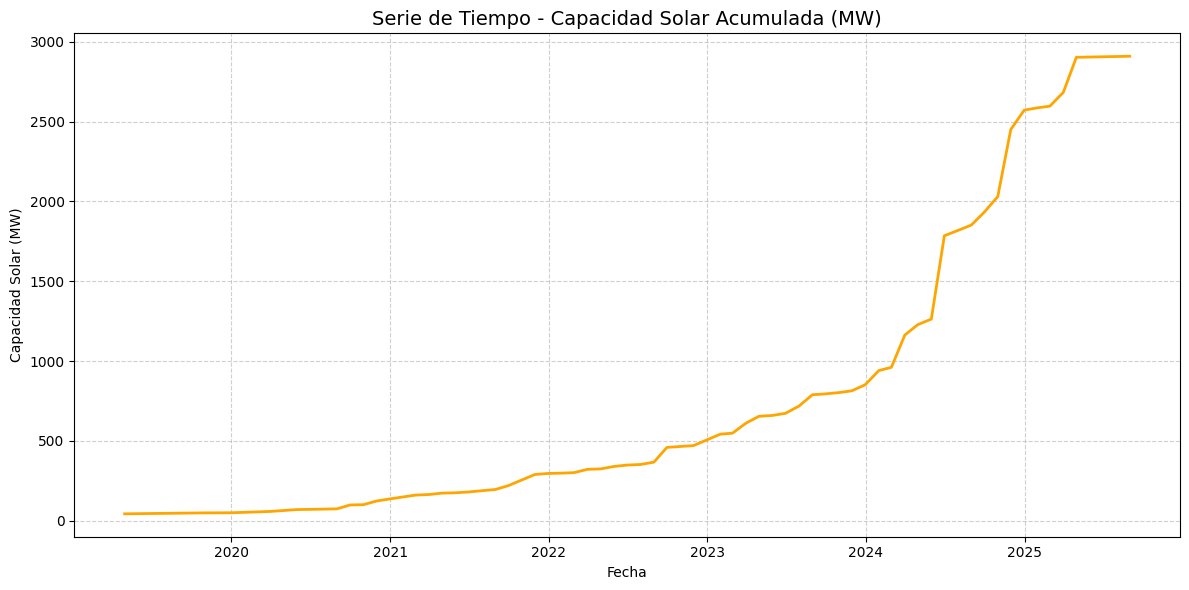

In [29]:
# Graficar la serie de tiempo continua
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SOLAR'], color='orange', linewidth=2)
plt.title('Serie de Tiempo - Capacidad Solar Acumulada (MW)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Capacidad Solar (MW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# V. Modelado

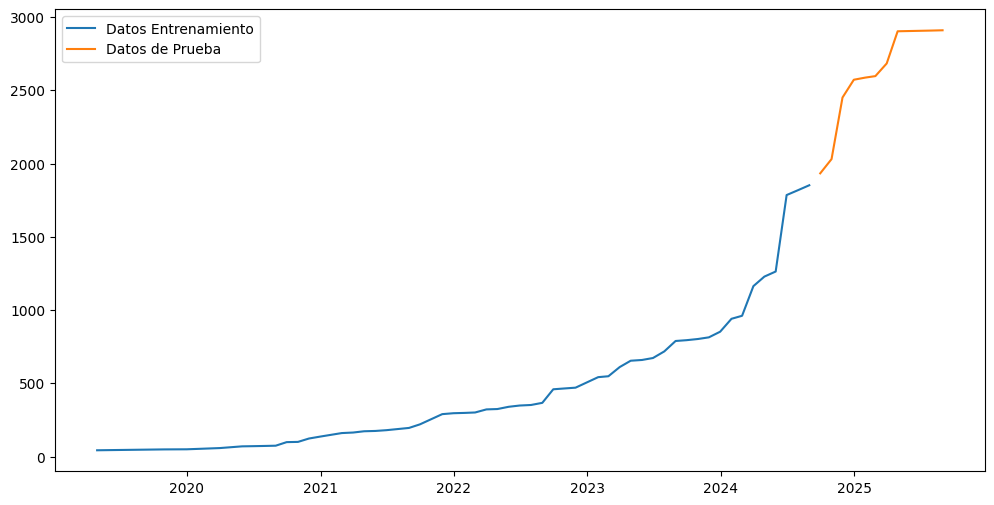

In [30]:
train_len = 65
train_td = df[["SOLAR"]][:train_len]
test_td = df[["SOLAR"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(test_td, label="Datos de Prueba")
plt.legend()
plt.show()

### **Suavizacion Exponencial Simple**

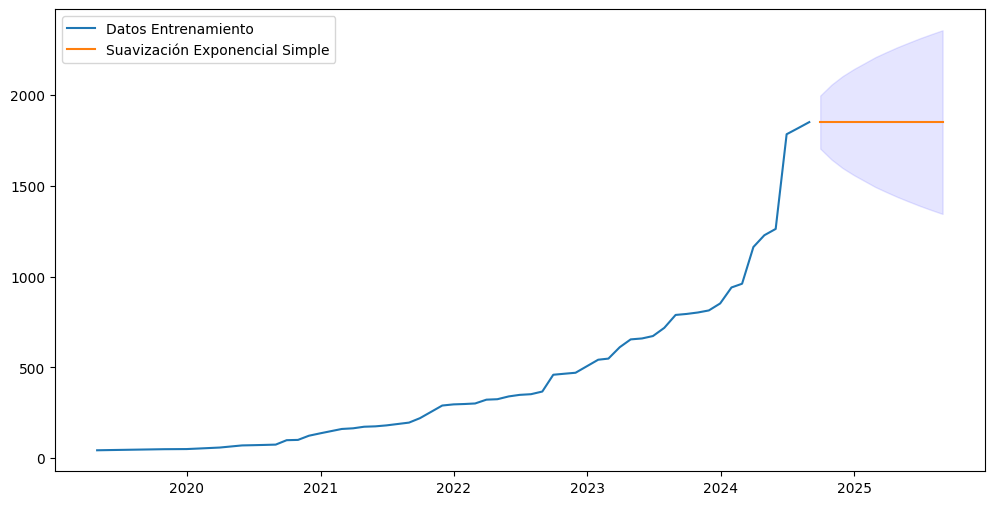

829.6368117774906


In [35]:
ets_model = ETSModel(endog=train_td["SOLAR"], error="add")
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis=1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
# print(preds)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'], label="Suavización Exponencial Simple")
plt.fill_between(preds.index, preds['lower_95'],
                 preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test_td, point_forecast))
print(rmse)

### **Suavizacion Exponencial Lineal (Holt)**

            Point_forecast     lower_95     upper_95
2024-09-30     2162.798892  2041.363319  2284.234465
2024-10-31     2342.264733  2192.016835  2492.512630
2024-11-30     2521.730574  2321.264950  2722.196197
2024-12-31     2701.196415  2433.808626  2968.584204
2025-01-31     2880.662256  2533.650375  3227.674138
2025-02-28     3060.128097  2623.249350  3497.006845
2025-03-31     3239.593939  2704.106184  3775.081694
2025-04-30     3419.059780  2777.200715  4060.918844
2025-05-31     3598.525621  2843.221488  4353.829754
2025-06-30     3777.991462  2902.683240  4653.299685
2025-07-31     3957.457303  2955.989862  4958.924745
2025-08-31     4136.923145  3003.470228  5270.376062


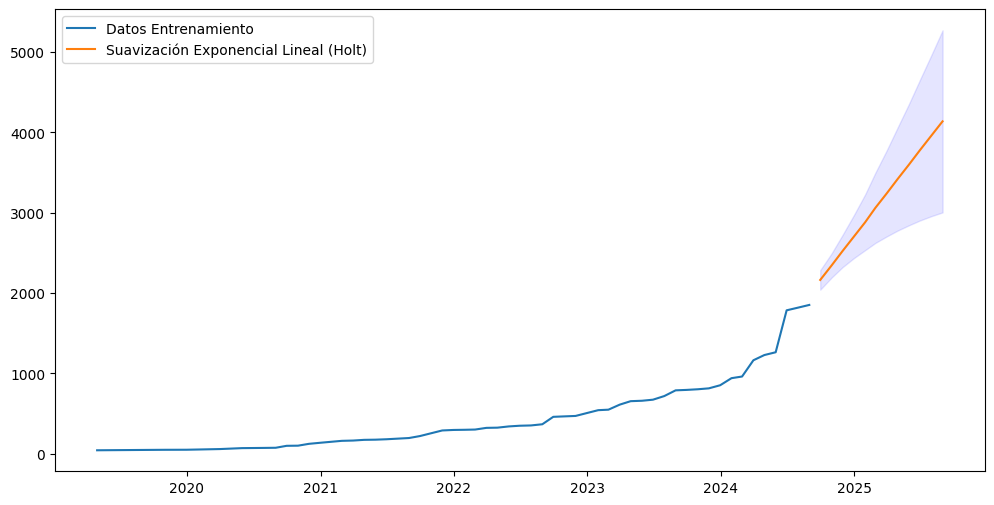

639.1927695007163


In [46]:
# Build model.
# ,seasonal="mul" )
ets_model = ETSModel(endog=train_td["SOLAR"], error="add", trend="add")
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis=1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],
         label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index,
                 preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

rmse_holt = np.sqrt(mean_squared_error(test_td, preds_holt['Point_forecast']))
print(rmse_holt)

## **Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [48]:
configurations = [
    ("add", "add", "add"),  # ETS(A,A,A)
    ("add", "add", "mul"),  # ETS(A,A,M)
    ("add", None, "add"),   # ETS(A,N,A)
    ("add", None, "mul"),   # ETS(A,N,M)
    ("mul", "add", None),   # ETS(M,A,N)
]

for err, trend, seas in configurations:
    model = ETSModel(endog=train_td["SOLAR"], error=err,
                     trend=trend, seasonal=seas)
    result = model.fit()
    forecast = result.forecast(len(test_td))
    rmse = np.sqrt(mean_squared_error(test_td, forecast))
    print(f"{err}-{trend}-{seas}: RMSE={rmse:.2f}")

add-add-add: RMSE=602.66
add-add-mul: RMSE=445.61
add-None-add: RMSE=855.72
add-None-mul: RMSE=1114.04
mul-add-None: RMSE=280.06


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [49]:
# Build model
ets_model = ETSModel(
    endog=train_td["SOLAR"], error="mul", trend="add", seasonal=None)
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis=1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast     lower_95     upper_95
2024-09-30     2031.571507  1738.585140  2332.609925
2024-10-31     2168.694104  1746.866659  2619.254797
2024-11-30     2305.816701  1706.744742  2889.589119
2024-12-31     2442.939298  1665.791336  3216.540461
2025-01-31     2580.061895  1590.440368  3565.746032
2025-02-28     2717.184492  1495.462487  3998.418767
2025-03-31     2854.307089  1446.753146  4387.248606
2025-04-30     2991.429686  1308.763607  4856.574475
2025-05-31     3128.552283  1259.837116  5279.300197
2025-06-30     3265.674880  1126.615951  5734.340918
2025-07-31     3402.797477  1021.862099  6379.422023
2025-08-31     3539.920074   912.577676  6950.372709


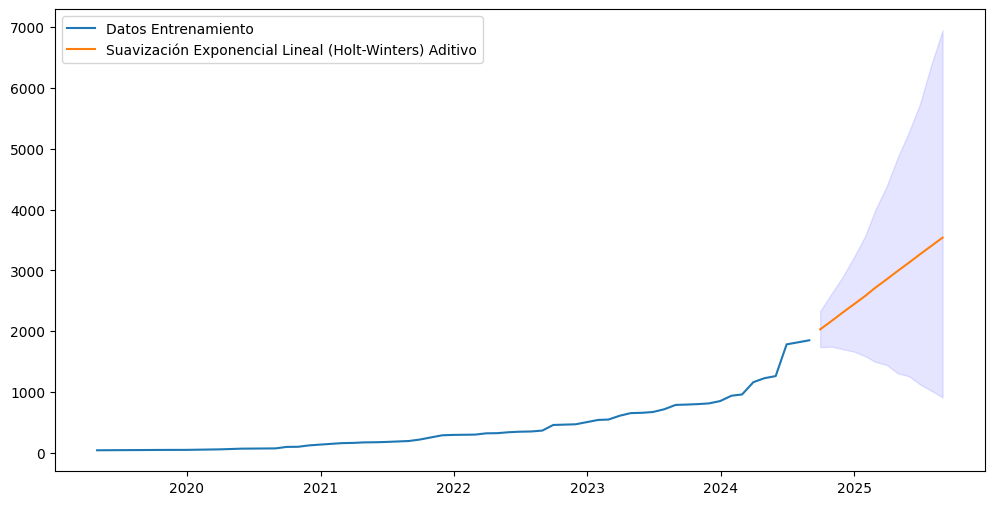

In [56]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],
         label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index,
                 preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [53]:
#print(ets_result.alpha, ets_result.beta,ets_result.gamma)
print(ets_result.alpha, ets_result.beta)

0.742634008731929 0.28977593630696125


In [54]:
rmse_hw_add = np.sqrt(mean_squared_error(
    test_td, preds_hw_add['Point_forecast']))
print(rmse_hw_add)

280.0619191554162
